In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

In [ ]:
class GCNLayer(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feat, adj_mat):
        num_neighbors = adj_mat.sum(dim = -1, keepdims=True)
        node_feat = self.projection(node_feat)
        node_feat = torch.bmm(adj_mat, node_feat)
        node_feat = node_feat / num_neighbors
        return node_feat

In [ ]:
import networkx as nx

nx_g = nx.from_edgelist([(2,1), (2,3), (4,2), (3,4)])

import matplotlib.pyplot as plt
fig = plt.figure()
nx.draw(nx_g, with_labels=True)

In [ ]:
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)

adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print(node_feats)

print(adj_matrix)

In [ ]:
layer = GCNLayer(c_in=2, c_out=2)

layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print(out_feats)

# GAT

In [ ]:
class GATLayer(nn.Module):
    def __init__(self, c_in, c_out, num_heads = 1, concat_heads = True, alpha = 0.2) -> None:
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads

        if self.concat_heads:
            assert c_out % num_heads == 0
            c_out = c_out // num_heads
        
        self.projection = nn.Linear(c_in, c_out*num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out))
        self.leakyrelu = nn.LeakyReLU(alpha)

        nn.init.xavier_uniform_(self.projection.weight.data, gain = 1.414)
        nn.init.xavier_uniform_(self.a.data, gain = 1.414)

    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)

        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        edges = adj_matrix.nonzero(as_tuple = False)

        node_feats_flat = node_feats.view(batch_size*num_nodes, self.num_heads, -1)

        edge_indices_row = edges[:, 0] * num_nodes + edges[:, 1]
        edge_indices_col = edges[:, 0] * num_nodes + edges[:, 2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim = 0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim = 0)
        ], dim = -1)

        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)

        attn_probs = F.softmax(attn_matrix, dim = 2)
        if print_attn_probs:
            print(attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats


In [ ]:
layer = GATLayer(c_in=2, c_out=2, num_heads=2)

layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix, print_attn_probs = True)

print(out_feats)

# Pytorch Geometric

In [ ]:
import torch_geometric
import torch_geometric.nn as g_nn
import torch_geometric.data as g_data

In [ ]:
import torch_geometric.datasets
from torch_geometric.transforms import NormalizeFeatures

dataset = torch_geometric.datasets.Planetoid(root='./data', name='Cora', transform=NormalizeFeatures())

In [ ]:
import numpy as np

data = dataset[0]
print(data['edge_index'])
print(data)

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_chan):
        super().__init__()
        torch.manual_seed(1123)
        self.conv1 = GCNConv(dataset.num_features, hidden_chan)
        self.conv2 = GCNConv(hidden_chan, dataset.num_classes)
    
    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
model = GCN(hidden_chan=16)
print(model)

In [ ]:
model = GCN(hidden_chan=16)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(model):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(model):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 101):
    loss = train(model)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

In [ ]:
test_acc = test()
print(test_acc)

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_chan, heads):
        super().__init__()
        torch.manual_seed(1123)
        self.conv1 = GATConv(dataset.num_features, hidden_chan)
        self.conv2 = GATConv(hidden_chan, dataset.num_classes)
    
    def forward(self, x, edge_index):
        print(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        raise Exception
        return x

def train(model):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(model, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[mask] == data.y[mask]
    test_acc = int(test_correct.sum()) / int(mask.sum())
    return test_acc
    
gatmodel = GAT(hidden_chan=8, heads=8)
optimizer = torch.optim.Adam(gatmodel.parameters(), lr = 0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
print(gatmodel)

In [ ]:
for epoch in range(1, 200):
    loss = train(gatmodel)
    val_acc = test(gatmodel, data.val_mask)
    test_acc = test(gatmodel, data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val; {val_acc:.4f}, \
          Test: {test_acc:.4f}')

In [ ]:
test_acc = test(gatmodel, mask=data.train_mask)
print(test_acc)

In [ ]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())


In [ ]:
print(data['edge_index'])

In [ ]:
from torch_geometric.utils import degree

row, col = data['edge_index']
print(row, col)
deg = degree

### nodes
* ports
	* id
* vessels
	* id
	* fish		
	* maybe? location
	* label (one hot vector)
	* maybe? country
	* ask for information about vessel types		

### edges
* dock
* ectr
	

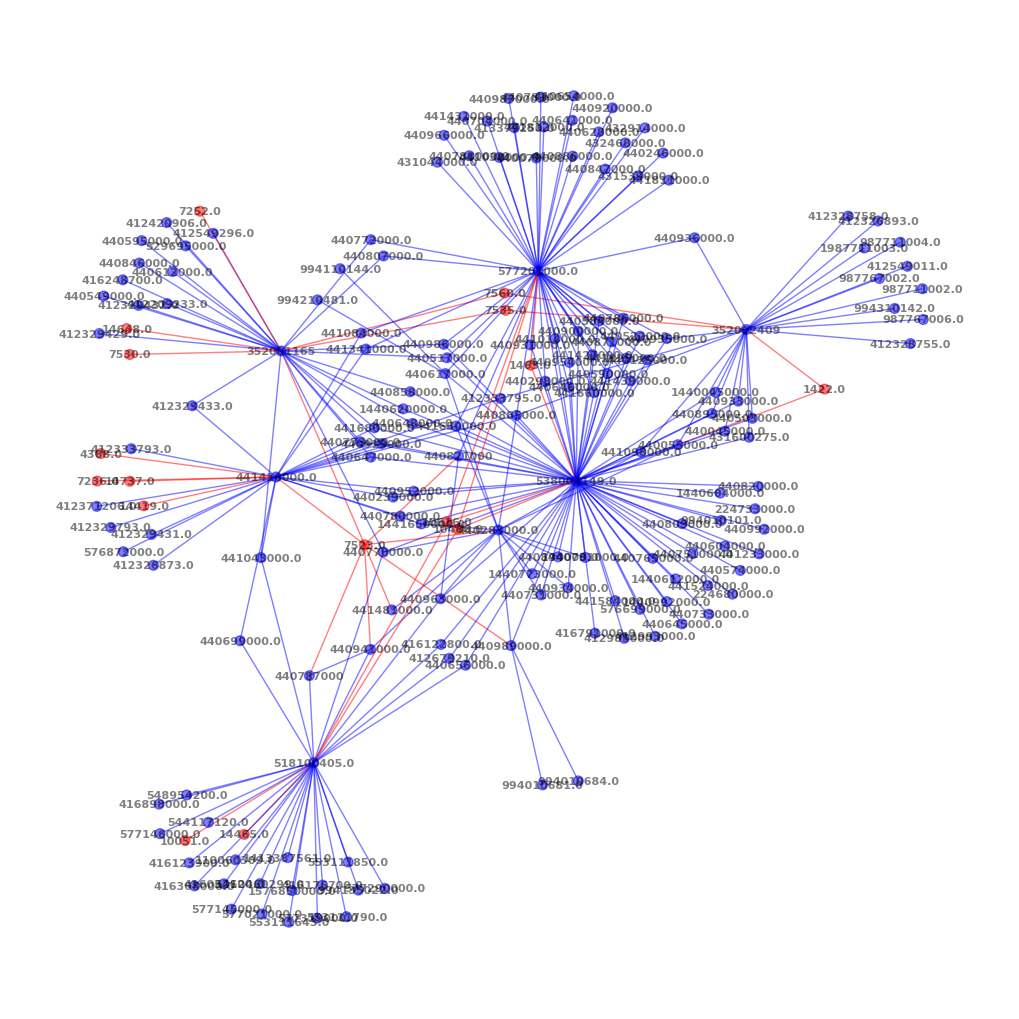

0.7934849262237549


In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import time

# nx_g = nx.from_edgelist([(2,1), (2,3), (4,2), (3,4)])

# import matplotlib.pyplot as plt
# fig = plt.figure()
# nx.draw(nx_g, with_labels=True)

data_events = pd.read_csv('data/Starboard/events.csv')
data_vessels = pd.read_csv('data/Starboard/vessels.csv')

t0 = time.time()
# Create Nodes and Edges
G = nx.Graph()

num_vessels = 0
n_colormap = {}
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}

for ind, data in data_events.iterrows():
    init_vessel = data['vessel_id']
    sec_vessel = data['vessel_id2']
    port = data['port_id']
    event = data['event_type']

    G.add_node(init_vessel, name = 'vessel', label = feature_dict[init_vessel])
    n_colormap[init_vessel] = 'blue'
    
    # if not np.isnan(sec_vessel):
    if not np.isnan(sec_vessel):# and sec_vessel in feature_dict:
        G.add_node(sec_vessel, name = 'vessel', label = feature_dict[sec_vessel] if sec_vessel in feature_dict else 0)
        G.add_edge(init_vessel, sec_vessel, event = event, color = 'blue')
        n_colormap[sec_vessel] = 'blue'

    if not np.isnan(port):
        G.add_node(port, name = 'port', label = 'port')
        G.add_edge(init_vessel, port, event = 'dock', color = 'red')
        n_colormap[port] = 'red'

#print(dict(G.nodes))
pos = nx.spring_layout(G, seed = 1123)

import matplotlib.pyplot as plt
plt.figure(1, figsize=(10,10))
e_colors = [G[u][v]['color'] for u,v in G.edges()]
nx.draw(G, pos, node_color = n_colormap.values(), edge_color = e_colors, node_size=50, alpha=0.5, with_labels = True, font_size = 8, font_weight = 'bold')
plt.axis('off')
plt.show()


t1 = time.time()
print(t1-t0)

In [12]:
import os.path as osp

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from torch_geometric.data.temporal import TemporalData
from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

import networkx as nx
import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Starboard data
events = ['FISH', 'PORT', 'ECTR']
event_dict = dict(zip(events, range(len(events))))
data_events = pd.read_csv('data/Starboard/events.csv')
data_vessels = pd.read_csv('data/Starboard/vessels.csv')
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}

# Initialise inputs 
src = np.zeros((len(data_events)))
dst = np.zeros((len(data_events)))
t = np.zeros((len(data_events)))
# features = (lat_n,lat_s,lon_e,lon_w,ves1,ves2)
features = np.zeros((len(data_events), 4))
y = np.zeros((len(data_events), len(events)))

# convert timesteps
data_events['start_time'] = pd.to_datetime(data_events['start_time'], format='%d/%m/%Y %H:%M')
data_events = data_events.sort_values(by='start_time').reset_index(drop=True)
timesteps = data_events['start_time'].dt.dayofyear

# add fish to events
data_events['event_type'] = data_events['event_type'].fillna('PORT')

for ind, data in data_events.iterrows():
    # Define source and dest array
    src[ind] = data['vessel_id']

    if not np.isnan(data['vessel_id2']):
        dst[ind] = data['vessel_id2']
    elif not np.isnan(data['port_id']):
        dst[ind] = data['port_id']
    else:
        dst[ind] = 0

    # Timestamp
    t[ind] = timesteps[ind]

    # Features
    features[ind] = np.array([data['lat_n'], data['lat_s'], data['lon_e'], data['lon_w']])

    # Even types
    event = data['event_type']
    y[ind][event_dict[event]] = 1

_, indexes = np.unique(np.concatenate((src, dst)), return_inverse=True)
print(src)
print(dst)
src, dst = np.split(indexes, 2)
features = np.nan_to_num(features)

src = torch.Tensor(src).type(torch.long)
dst = torch.Tensor(dst).type(torch.long)
t = torch.Tensor(t).type(torch.long)
features = torch.Tensor(features)
y = torch.Tensor(y)

final_dataset = TemporalData(src, dst, t, features, y=y)

print(final_dataset)
print(len(G.nodes()))
print(features)
# _, uniq = np.unique(pd.concat((data_events['vessel_id'], data_events['vessel_id2'], data_events['port_id'])), return_inverse=True)
# print(indexes)
# print(uniq)
# print(np.array_equal(uniq, indexes))
# vals, counts = np.unique(dst, return_counts=True)
# print(counts)
# print(vals)

[3.52001165e+08 4.41098000e+08 4.40770000e+08 ... 3.52001165e+08
 5.38004149e+08 3.52001165e+08]
[4.12329429e+08 0.00000000e+00 0.00000000e+00 ... 4.40986000e+08
 4.40751000e+08 4.40772000e+08]
TemporalData(src=[2229], dst=[2229], t=[2229], msg=[2229, 4], y=[2229, 3])
183
tensor([[  -0.6426,   -0.6716,  159.1645,  159.1010],
        [  11.0267,   10.7133, -171.3326, -172.5636],
        [   4.0856,    3.9449,  177.3412,  176.5370],
        ...,
        [   3.5694,    3.5431,  179.7119,  179.6929],
        [  11.9641,   11.9366,  177.9725,  177.9508],
        [   3.5459,    3.5248,  179.6997,  179.6917]])


In [ ]:
final_dataset = final_dataset.to(device)

train_data, val_data, test_data = final_dataset.train_val_test_split(
    val_ratio=0.15, test_ratio=0.15)

train_loader = TemporalDataLoader(
    train_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)
val_loader = TemporalDataLoader(
    val_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)
test_loader = TemporalDataLoader(
    test_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)

neighbors = torch.empty((final_dataset.num_nodes, 10), dtype=torch.long)

neighbor_loader = LastNeighborLoader(final_dataset.num_nodes, size=10, device=device)

train1 = train_loader.__iter__().__next__()
print(train1)
#print(len(np.unique(train1['src'])) + len(np.unique(np.concatenate((train1['dst'], train1['neg_dst'])))))
print(train1['src'])
print(train1['dst'])
print(train1['t'])
print(train1['msg'])
print(train1['neg_dst'])
print(train1['n_id'])

In [ ]:
print(feature_dict)

In [ ]:
import os.path as osp

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

path = osp.join(osp.abspath(''), 'data', 'JODIE')
dataset = JODIEDataset(path, name='wikipedia')
data = dataset[0]

# For small datasets, we can put the whole dataset on GPU and thus avoid
# expensive memory transfer costs for mini-batches:
data = data.to(device)

train_data, val_data, test_data = data.train_val_test_split(
    val_ratio=0.15, test_ratio=0.15)

print(dataset[0])
print(dataset[0]['y'])
print(dataset[0].num_nodes)

In [ ]:
train_loader = TemporalDataLoader(
    train_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)
val_loader = TemporalDataLoader(
    val_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)
test_loader = TemporalDataLoader(
    test_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)
neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)

train1 = train_loader.__iter__().__next__()
print(train1)
print(len(np.unique(train1['src'])) + len(np.unique(np.concatenate((train1['dst'], train1['neg_dst'])))))
print(train1['src'])
print(train1['dst'])
print(train1['t'])
print(train1['msg'])
print(train1['neg_dst'])
print(train1['n_id'])

# Train TGN

This just predicts if a link would exist without considering the future time step specifically

In [1]:
# This code achieves a performance of around 96.60%. However, it is not
# directly comparable to the results reported by the TGN paper since a
# slightly different evaluation setup is used here.
# In particular, predictions in the same batch are made in parallel, i.e.
# predictions for interactions later in the batch have no access to any
# information whatsoever about previous interactions in the same batch.
# On the contrary, when sampling node neighborhoods for interactions later in
# the batch, the TGN paper code has access to previous interactions in the
# batch.
# While both approaches are correct, together with the authors of the paper we
# decided to present this version here as it is more realsitic and a better
# test bed for future methods.

import os.path as osp

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from torch_geometric.data.temporal import TemporalData
from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

# Starboard data
events = ['FISH', 'PORT', 'ECTR']
event_dict = dict(zip(events, range(len(events))))
data_events = pd.read_csv('data/Starboard/events.csv')
data_vessels = pd.read_csv('data/Starboard/vessels.csv')
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}

# Initialise inputs 
src = np.zeros((len(data_events)))
dst = np.zeros((len(data_events)))
t = np.zeros((len(data_events)))
# features = (lat_n,lat_s,lon_e,lon_w,ves1,ves2)
features = np.zeros((len(data_events), 4))
y = np.zeros((len(data_events), len(events)))

# convert timesteps
data_events['start_time'] = pd.to_datetime(data_events['start_time'], format='%d/%m/%Y %H:%M')
data_events = data_events.sort_values(by='start_time').reset_index(drop=True)
timesteps = data_events['start_time'].dt.dayofyear

# add fish to events
data_events['event_type'] = data_events['event_type'].fillna('PORT')

for ind, data in data_events.iterrows():
    # Define source and dest array
    src[ind] = data['vessel_id']

    if not np.isnan(data['vessel_id2']):
        dst[ind] = data['vessel_id2']
    elif not np.isnan(data['port_id']):
        dst[ind] = data['port_id']
    else:
        dst[ind] = 0

    # Timestamp
    t[ind] = timesteps[ind]

    # Features
    features[ind] = np.array([data['lat_n'], data['lat_s'], data['lon_e'], data['lon_w']])

    # Even types
    event = data['event_type']
    y[ind][event_dict[event]] = 1

vals, indexes = np.unique(np.concatenate((src, dst)), return_inverse=True)
src, dst = np.split(indexes, 2)
features = np.nan_to_num(features)

src = torch.Tensor(src).type(torch.long)
dst = torch.Tensor(dst).type(torch.long)
t = torch.Tensor(t).type(torch.long)
features = torch.Tensor(features)
y = torch.Tensor(y)

data = TemporalData(src=src, dst=dst, t=t, msg=features, y=y)

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'JODIE')
# dataset = JODIEDataset(path, name='wikipedia')
# data = dataset[0]

# For small datasets, we can put the whole dataset on GPU and thus avoid
# expensive memory transfer costs for mini-batches:
data = data.to(device)

train_data, val_data, test_data = data.train_val_test_split(
    val_ratio=0.15, test_ratio=0.15)

train_loader = TemporalDataLoader(
    train_data,
    batch_size=100,
    neg_sampling_ratio=1.0,
)
val_loader = TemporalDataLoader(
    val_data,
    batch_size=100,
    neg_sampling_ratio=1.0,
)
test_loader = TemporalDataLoader(
    test_data,
    batch_size=100,
    neg_sampling_ratio=1.0,
)

neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)


class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // 2, heads=2,
                                    dropout=0.1, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = self.lin_src(z_src) + self.lin_dst(z_dst)
        h = h.relu()
        return self.lin_final(h)


memory_dim = time_dim = embedding_dim = 100

memory = TGNMemory(
    data.num_nodes,
    data.msg.size(-1),
    memory_dim,
    time_dim,
    message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)

gnn = GraphAttentionEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    msg_dim=data.msg.size(-1),
    time_enc=memory.time_enc,
).to(device)

link_pred = LinkPredictor(in_channels=embedding_dim).to(device)

optimizer = torch.optim.Adam(
    set(memory.parameters()) | set(gnn.parameters())
    | set(link_pred.parameters()), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

# Helper vector to map global node indices to local ones.
assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)


def train():
    memory.train()
    gnn.train()
    link_pred.train()

    memory.reset_state()  # Start with a fresh memory.
    neighbor_loader.reset_state()  # Start with an empty graph.

    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        # Get updated memory of all nodes involved in the computation.
        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        # y_true = torch.stack((torch.ones(len(batch)).to(device), batch.t), dim=1)
        # loss = criterion(pos_out, y_true)

        loss = criterion(pos_out, torch.ones_like(pos_out))
        loss += criterion(neg_out, torch.zeros_like(neg_out))

        # Update memory and neighbor loader with ground-truth state.
        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

        loss.backward()
        optimizer.step()
        memory.detach()
        total_loss += float(loss) * batch.num_events

    return total_loss / train_data.num_events


@torch.no_grad()
def test(loader):
    memory.eval()
    gnn.eval()
    link_pred.eval()

    torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.

    aps, aucs = [], []
    for batch in loader:
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
        y_true = torch.cat(
            [torch.ones(pos_out.size(0)),
             torch.zeros(neg_out.size(0))], dim=0)

        aps.append(average_precision_score(y_true, y_pred))
        aucs.append(roc_auc_score(y_true, y_pred))

        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)
    
    return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean())

for epoch in range(1, 51):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
    val_ap, val_auc = test(val_loader)
    test_ap, test_auc = test(test_loader)
    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')

Epoch: 01, Loss: 2.0506
Val AP: 0.6024, Val AUC: 0.6283
Test AP: 0.6641, Test AUC: 0.6772
Epoch: 02, Loss: 1.2933
Val AP: 0.9494, Val AUC: 0.9527
Test AP: 0.7766, Test AUC: 0.7526
Epoch: 03, Loss: 0.8195
Val AP: 0.9513, Val AUC: 0.9588
Test AP: 0.7664, Test AUC: 0.7353
Epoch: 04, Loss: 0.6938
Val AP: 0.9407, Val AUC: 0.9594
Test AP: 0.7688, Test AUC: 0.7568
Epoch: 05, Loss: 0.7202
Val AP: 0.9415, Val AUC: 0.9606
Test AP: 0.7736, Test AUC: 0.7570
Epoch: 06, Loss: 0.7167
Val AP: 0.9561, Val AUC: 0.9673
Test AP: 0.7737, Test AUC: 0.7522
Epoch: 07, Loss: 0.6817
Val AP: 0.9548, Val AUC: 0.9675
Test AP: 0.7807, Test AUC: 0.7599
Epoch: 08, Loss: 0.6557
Val AP: 0.9557, Val AUC: 0.9685
Test AP: 0.7825, Test AUC: 0.7740
Epoch: 09, Loss: 0.6489
Val AP: 0.9553, Val AUC: 0.9674
Test AP: 0.7832, Test AUC: 0.7759
Epoch: 10, Loss: 0.6466
Val AP: 0.9571, Val AUC: 0.9687
Test AP: 0.7863, Test AUC: 0.7803
Epoch: 11, Loss: 0.6201
Val AP: 0.9652, Val AUC: 0.9736
Test AP: 0.7864, Test AUC: 0.7819
Epoch: 12,

In [59]:
# Get some predictions to show
ind_map = {vals[i]: i for i in range(len(vals))}
rev_ind_map = {i: vals[i] for i in range(len(vals))}

permut = np.array(np.meshgrid(vals, vals)).T.reshape(-1,2)
pred_src, pred_dst = np.hsplit(permut, 2)

pred_src = np.vectorize(ind_map.get)(pred_src)
pred_dst = np.vectorize(ind_map.get)(pred_dst)

pred_src = torch.Tensor(pred_src).type(torch.long)
pred_dst = torch.Tensor(pred_dst).type(torch.long)

pred_data = TemporalData(src=pred_src, dst=pred_dst)

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'JODIE')
# dataset = JODIEDataset(path, name='wikipedia')
# data = dataset[0]

# For small datasets, we can put the whole dataset on GPU and thus avoid
# expensive memory transfer costs for mini-batches:
pred_data = pred_data.to(device)

batch_size = 200

pred_loader = TemporalDataLoader(
    pred_data,
    batch_size=batch_size
)

final_pred = torch.zeros((pred_src.shape[0], 3)).to(device)

with torch.no_grad():
    memory.eval()
    gnn.eval()
    link_pred.eval()

    torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.

    for ind, batch in enumerate(pred_loader):
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        cur_pred = torch.stack((pos_out.sigmoid().view(-1, 1), batch.src, batch.dst), axis = 1)
        final_pred[batch_size*ind:batch_size*(ind+1)] = cur_pred[:,:,0]

final_dataframe = pd.DataFrame(final_pred.detach().cpu().numpy())
final_dataframe = final_dataframe.replace({1:rev_ind_map, 2:rev_ind_map})

In [60]:
print(final_dataframe)

              0             1             2
0      0.850852  0.000000e+00  0.000000e+00
1      0.245819  0.000000e+00  1.422000e+03
2      0.200453  0.000000e+00  1.463000e+03
3      0.109125  0.000000e+00  4.368000e+03
4      0.140988  0.000000e+00  7.236000e+03
...         ...           ...           ...
33851  0.185269  1.987711e+09  1.440773e+09
33852  0.374700  1.987711e+09  1.440992e+09
33853  0.267824  1.987711e+09  1.441650e+09
33854  0.295344  1.987711e+09  1.576850e+09
33855  0.187575  1.987711e+09  1.987711e+09

[33856 rows x 3 columns]
